In [1]:
# load some libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import integrate
from scipy.special import sph_harm
from scipy.special import erf
# import library for hf routines
import hf_routines as hf
# import library for setting up plots
import plotting as myplt

In [17]:
# set STO-3G basis and atoms
N = 2
zeta = [1.24,1.24]
R = np.empty((2,3),dtype=float)
R[0,0] = R[0,1] = R[0,2] = 0.0
R[1,0] = 1.4
R[1,1] = R[1,2] = 0.0
Z = [1.0,1.0]
basis_set = [hf.sto(3,zeta[i],R[i,:]) for i in range(2)]
atoms = [hf.atom(R[i,:],Z[i]) for i in range(2)]

In [18]:
def CI(orbitalEnergies,twoE,atoms):
    # Populate 2x2 Hamiltonian matrix
    H_CI = np.empty((2,2),dtype=float)
    H_CI[0,0] = 2*orbitalEnergies[0] - twoE[0,0,0,0]  # 2e1 - J11
    H_CI[0,1] = H_CI[1,0] = twoE[0,1,1,0]  # K12
    H_CI[1,1] = 2*orbitalEnergies[1] - 4*twoE[0,0,1,1] + twoE[1,1,1,1] + 2*twoE[0,1,1,0] # 2e2 -4J12 + J22 +2K12
    # diagonalize
    energy, CIs = np.linalg.eig(H_CI)
    idx = energy.argsort()
    energy = energy[idx]
    CIs = CIs[:,idx]
    nAtoms = len(atoms)
    Enucl = 0.0
    for atom1 in range(nAtoms-1):
        for atom2 in range(atom1+1,nAtoms):
            diff = atoms[atom1].pos - atoms[atom2].pos
            dist = np.linalg.norm(diff)
            Enucl += atoms[atom1].charge*atoms[atom2].charge/dist
    return energy[0]+Enucl, CIs

In [25]:
def mp2(orbitalEnergies,twoE,N):
    M = len(orbitalEnergies)
    mp2_energy = 0.0
    for a in range(M-1):
        for b in range(a+1,M):
            for r in range(M-1):
                for s in range(r+1,M):
                    denom = orbitalEnergies[a]+orbitalEnergies[b]-orbitalEnergies[r]-orbitalEnergies[s]
                    if denom != 0.0:
                        mp2_energy += twoE[a,b,r,s]**2/denom
    mp2_energy = twoE[0,1,1,0]**2/(2*(orbitalEnergies[0]-orbitalEnergies[1]))
    return mp2_energy

def mp3(orbitalEnergies,twoE,N):
    mp3_energy = twoE[0,1,1,0]**2*(twoE[0,0,0,0]+twoE[1,1,1,1]-4*twoE[0,0,1,1]+2*twoE[0,1,1,0])/(4*(orbitalEnergies[0]-orbitalEnergies[1])**2)
    return mp3_energy

In [26]:
# scan R - can use optimal C
r = np.arange(0.5,6.0,0.05)
ci_energy = np.empty(r.size)
hf_energy = np.empty(r.size)
mp2_energy = np.empty(r.size)
mp3_energy = np.empty(r.size)
ci_coeff = np.empty((r.size,2))
for i in range(r.size):
    basis_set[1].R[0] = r[i]
    atoms[1].pos[0] = r[i]
    hf_energy[i], C, orbitalEnergies, hf_twoE = hf.perform_hf(basis_set,atoms)
    ci_energy[i], CIs = CI(orbitalEnergies,hf_twoE,atoms)
    ci_coeff[i,:] = CIs[:,0]
    mp2_energy[i] = hf_energy[i] + mp2(orbitalEnergies,hf_twoE,N)
    mp3_energy[i] = mp2_energy[i] + mp3(orbitalEnergies,hf_twoE,N)

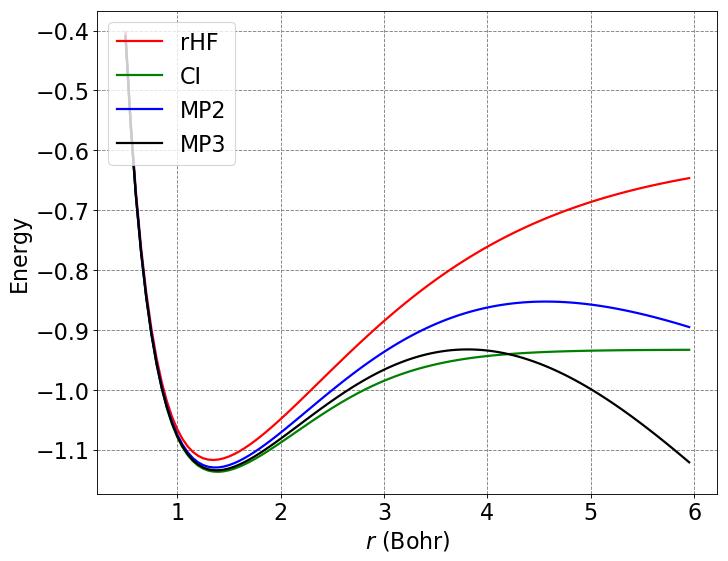

In [29]:
# plot results
ax = myplt.define_figure(xlabel="$r$ (Bohr)",ylabel="Energy")
ax.plot(r,hf_energy,lw=2,label='rHF',c='r')
ax.plot(r,ci_energy,lw=2,label='CI',c='g')
ax.plot(r,mp2_energy,lw=2,label='MP2',c='b')
ax.plot(r,mp3_energy,lw=2,label='MP3',c='k')

ax.legend(fontsize=20,loc=2)

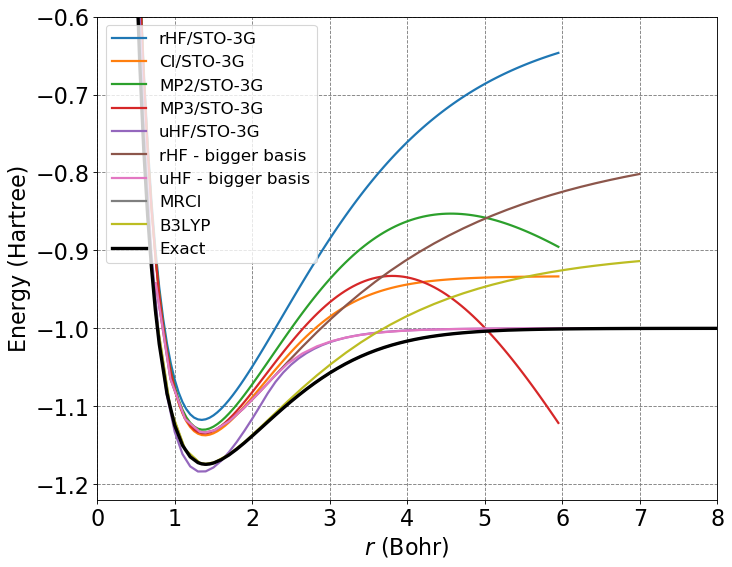

In [30]:
# plot results with other methods
# load data for other methods from files 
uhf = np.loadtxt("uhf_energy_scan.txt")
others = np.loadtxt("h2_various_methods.txt",skiprows=1)  # has a header line
exact = np.loadtxt("h2_kolos_wolniewicz.txt",skiprows=1)  # has a header line
# initialize figure using my plotting routine 
ax = myplt.define_figure(xlabel="$r$ (Bohr)",ylabel="Energy (Hartree)")
# minimal basis results
ax.plot(r,hf_energy,lw=2,label='rHF/STO-3G')
ax.plot(r,ci_energy,lw=2,label='CI/STO-3G')
ax.plot(r,mp2_energy,lw=2,label='MP2/STO-3G')
ax.plot(r,mp3_energy,lw=2,label='MP3/STO-3G')
ax.plot(uhf[:,0],uhf[:,1]-uhf[-1,1]-1,lw=2,label='uHF/STO-3G')
# plot various other results
ax.plot(others[:,0]*1.88973,others[:,1],lw=2,label='rHF - bigger basis')  # r is in units of Angstroms
ax.plot(others[:,0]*1.88973,others[:,2],lw=2,label='uHF - bigger basis')  # r is in units of Angstroms
ax.plot(others[:,0]*1.88973,others[:,6],lw=2,label='MRCI')                # r is in units of Angstroms
ax.plot(others[:,0]*1.88973,others[:,7],lw=2,label='B3LYP')               # r is in units of Angstroms
ax.plot(exact[:,0],exact[:,1],lw=3,c='k',label='Exact')                   # The Kolos Wolniewicz "exact" results
# change x and y dimensions of plot to focus more on well
ax.set_ylim([-1.22,-0.6])
ax.set_xlim([0,8])
# make a legend
ax.legend(fontsize=15)